## Only test with Pre-Trained Model

In [14]:
model_name = "Original-Pretrained-R2plus1DMotionSegNet_model.pth"

In [16]:
%config Completer.use_jedi = False

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.transform_utils import generate_2dmotion_field
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet
from src.echonet_dataset import EchoNetDynamicDataset
from src.clasfv_losses import deformation_motion_loss, motion_seg_loss, DiceLoss, categorical_dice
from src.train_test import train, test

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)

In [17]:
model_save_path = f"save_models/{model_name}"

model = torch.nn.DataParallel(R2plus1D_18_MotionNet())
model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'R2+1D MotionNet has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')

model.eval();

R2+1D MotionNet has 31575731 parameters.


## Only load valid data stuff to work with the pretrained model

In [18]:
with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

In [19]:
batch_size = 4
num_workers = max(4, cpu_count()//2)

def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [20]:
valid_dataset = EchoNetDynamicDataset(split='val', subset_indices=valid_mask, period=1)

valid_dataloader = DataLoader(valid_dataset, 
                              batch_size=batch_size, 
                              num_workers=num_workers,
                              shuffle=False, 
                              pin_memory=("cuda"),
                              worker_init_fn=worker_init_fn_valid
                             )

100%|██████████| 16/16 [00:01<00:00, 12.76it/s]


### Visualiation

In [21]:
i = 0
threshold = 34
# threshold = np.random.randint(0, len(valid_dataloader))

np.random.seed()
for data in valid_dataloader:
    i += 1
    data = data
    if i > threshold:
        break

In [22]:
valid_dataloader

In [23]:
video, (filename, EF, es_clip_index, ed_clip_index, es_index, ed_index, es_frame, ed_frame, es_label, ed_label) = data

In [24]:
print(type(video))

<class 'torch.Tensor'>


### Print all 32 Frames of one clip (this should be a single unit of the batches passed in?)

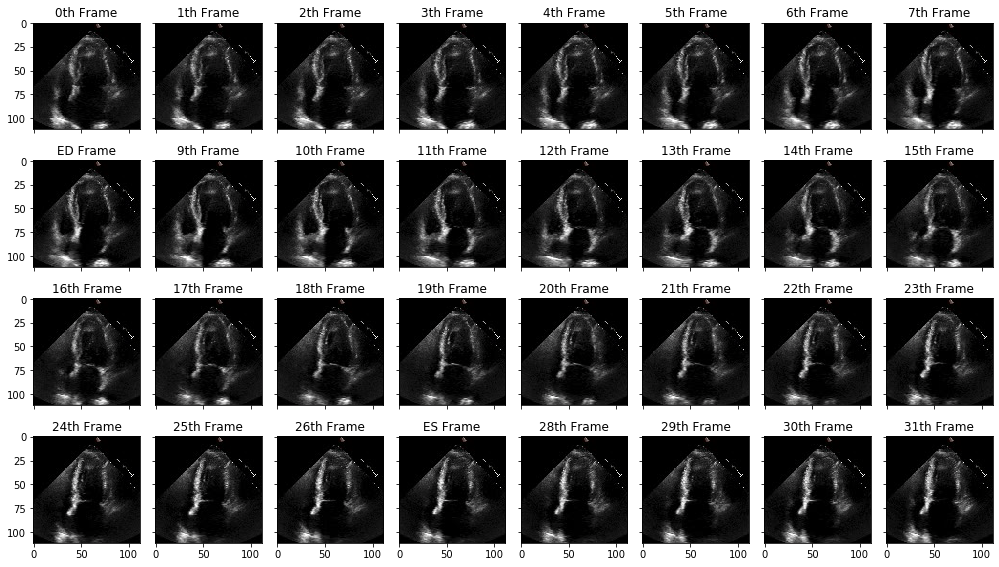

In [25]:
batch_inside_index = 0 # which part of the batch we are looking at ? 

fig, ax = plt.subplots(4, 8, figsize=(14, 8), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j == ed_clip_index[batch_inside_index]:
            ax[i][j].set_title("ED Frame")
        elif i * 8 + j == es_clip_index[batch_inside_index]:
            ax[i][j].set_title("ES Frame")
        else:
            ax[i][j].set_title("{:d}th Frame".format(i * 8 + j ))
        ax[i][j].imshow(video[batch_inside_index, :, i * 8 + j].cpu().detach().numpy().transpose([1, 2, 0]))
        
plt.tight_layout()
plt.show()

In [26]:
%%capture

from src.utils.echo_utils import makeVideo

vid_animation = makeVideo(video.cpu().detach().numpy()[batch_inside_index].transpose([1, 2, 3, 0]))

In [27]:
vid_animation

## That's cool and all, but that's just the validation set data. What do they look like AFTER they have been segmented?

### Let's pass the above clip (video) to our model

In [14]:
segmentation_output, motion_output = model(torch.Tensor(video))

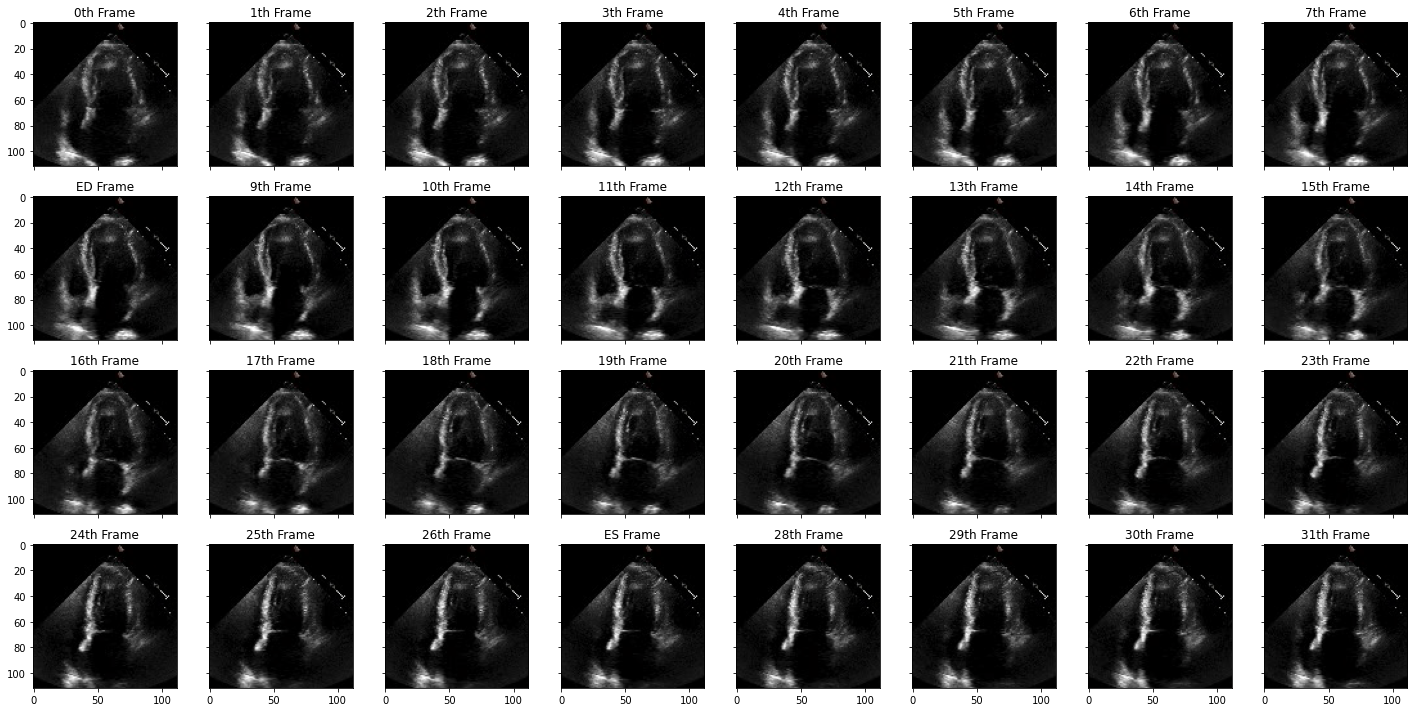

In [15]:
# ORIGINAL
batch_inside_index = 0
fig, ax = plt.subplots(4, 8, figsize=(20, 10), sharex=True, sharey=True)

for i in range(4):
    for j in range(8):
            # figure out what label to give
            if i * 8 + j == ed_clip_index[batch_inside_index]:
                ax[i][j].set_title("ED Frame")
            elif i * 8 + j == es_clip_index[batch_inside_index]:
                ax[i][j].set_title("ES Frame")
            else:
                ax[i][j].set_title("{:d}th Frame".format(i * 8 + j ))
            # show unsegmeneted image
            ax[i][j].imshow(video[batch_inside_index, :, i * 8 + j].cpu().detach().numpy().transpose([1, 2, 0]))
        
plt.tight_layout()
plt.show()

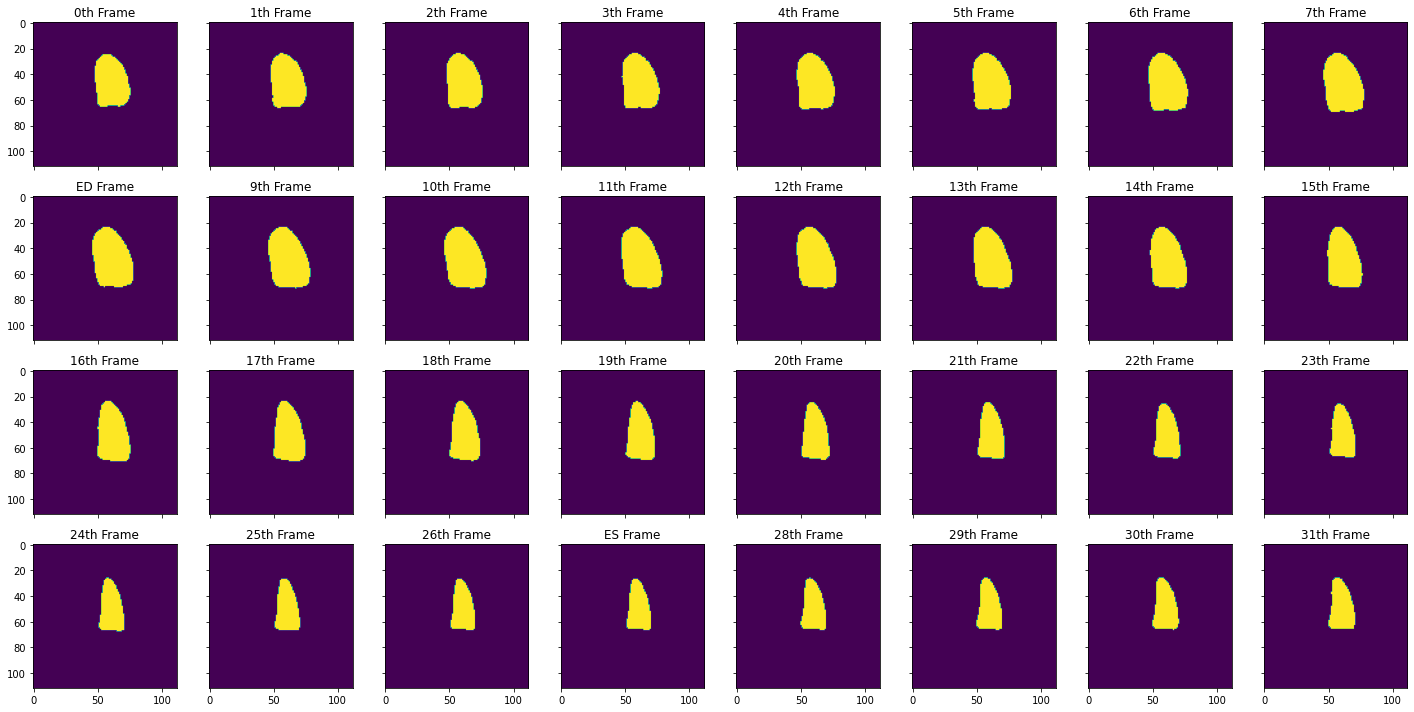

In [23]:
# SEGMENTED BY MODEL
segmentation = torch.argmax(segmentation_output, 1).cpu().detach().numpy()[batch_inside_index]
fig, ax = plt.subplots(4, 8, figsize=(20, 10), sharex=True, sharey=True)
for i in range(4):
    for j in range(8):
        if i * 8 + j == ed_clip_index[batch_inside_index]:
            ax[i][j].set_title("ED Frame")
        elif i * 8 + j == es_clip_index[batch_inside_index]:
            ax[i][j].set_title("ES Frame")
        else:
            ax[i][j].set_title("{:d}th Frame".format(i * 8 + j))
        ax[i][j].imshow(segmentation[i * 8 + j])
        
plt.tight_layout()
plt.show()

## Let's look at the unsegmented and segmented frames back to back:

Left ventricle in yellow, anything else in purple.

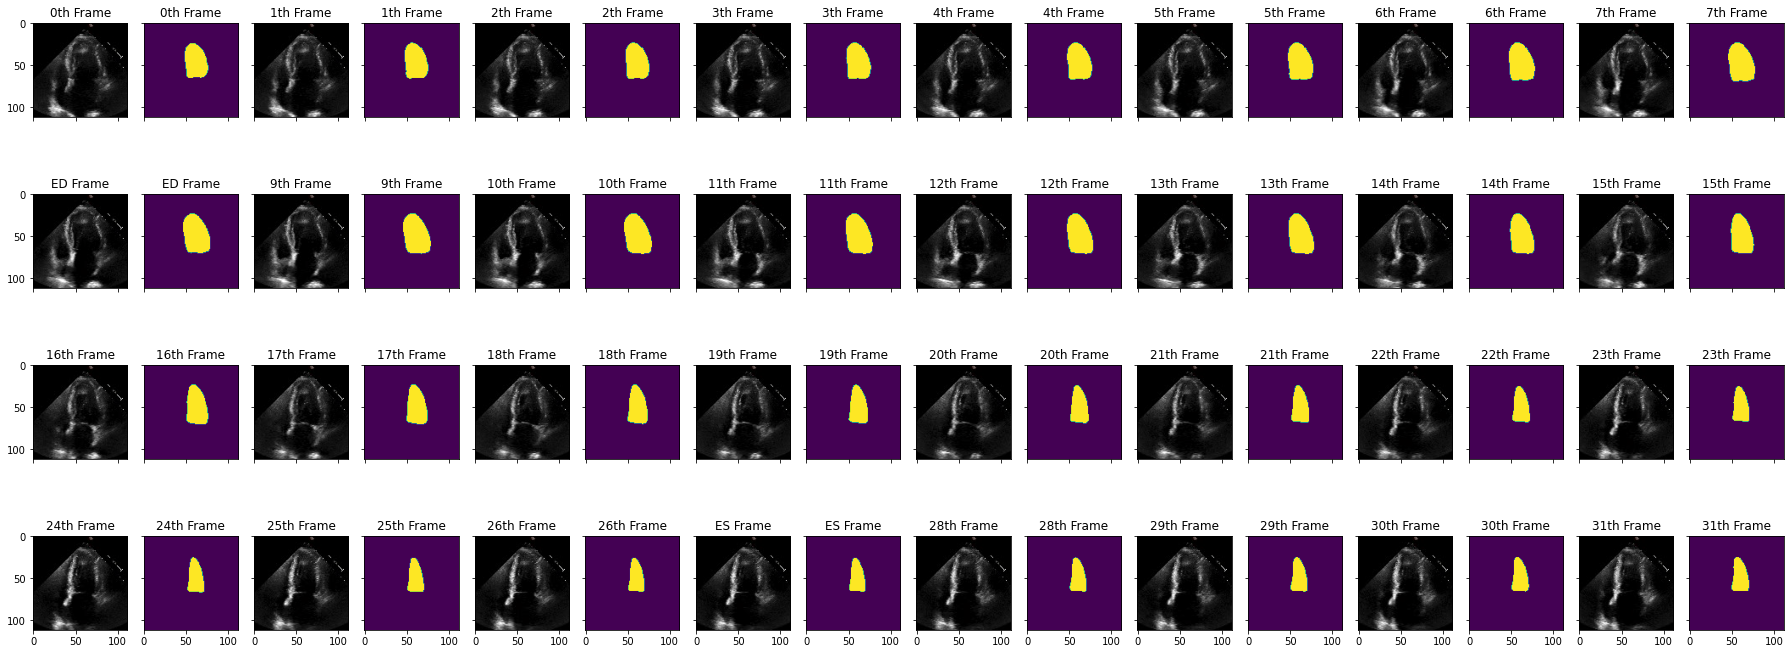

In [24]:
fig, ax = plt.subplots(4, 16, figsize=(25, 10), sharex=True, sharey=True)
for i in range(4):
    # each j iteration we show 2 figs (unsegmented and segmented frame)
    ind = 0
    for j in range(8):
        # unsegmented:
        
        # figure out what label to give
        if i * 8 + j == ed_clip_index[batch_inside_index]:
            ax[i][ind].set_title("ED Frame")
        elif i * 8 + j == es_clip_index[batch_inside_index]:
            ax[i][ind].set_title("ES Frame")
        else:
            ax[i][ind].set_title("{:d}th Frame".format(i * 8 + j ))
        # show unsegmeneted image
        ax[i][ind].imshow(video[batch_inside_index, :, i * 8 + j].cpu().detach().numpy().transpose([1, 2, 0]))
        
        ind += 1
        
        # segmented:
        if i * 8 + j == ed_clip_index[batch_inside_index]:
            ax[i][ind].set_title("ED Frame")
        elif i * 8 + j == es_clip_index[batch_inside_index]:
            ax[i][ind].set_title("ES Frame")
        else:
            ax[i][ind].set_title("{:d}th Frame".format(i * 8 + j))
        ax[i][ind].imshow(segmentation[i * 8 + j])
        
        ind += 1

plt.tight_layout()
plt.show()